In [425]:
#Exctrating zero rates from traded data 

In [426]:
import numpy as np
import quandl 
import pandas as pd
import matplotlib.pyplot as plt
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve, NelsonSiegelCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, calibrate_nss_ols
import datetime as dt

In [427]:
quandl.ApiConfig.api_key = "ETVLgt11D2qC12N8pPku" 
today = dt.date.today()
year_ago = today - dt.timedelta(days=365) 
importrates = quandl.get("USTREASURY/YIELD", start_date = year_ago, end_date = today) #Importing data for the last year, assuming 252 trading days
tyields = importrates.drop(['1 MO', '2 MO', '3 MO', '6 MO', '1 YR', '20 YR'], axis=1)

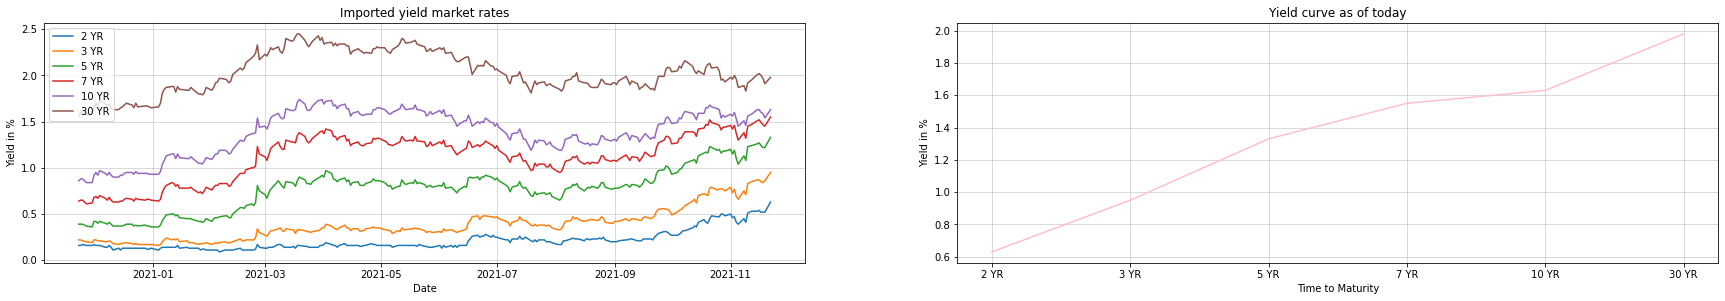

In [428]:
columns = tyields.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(tyields[col])
    plt.xlabel('Date')
    plt.ylabel('Yield in %')
    plt.title('Imported yield market rates')
    plt.grid(alpha = 0.6)
    plt.legend(columns)

plt.subplot(3,2,2)
plt.plot(tyields.iloc[-1], color = 'pink')
plt.ylabel('Yield in %')
plt.xlabel('Time to Maturity')
plt.title('Yield curve as of today')
plt.grid(alpha = 0.6)

In [429]:
# d3a3a61f14441d0538d5bdcdda054aba FRED API 
from fredapi import Fred
fred = Fred(api_key='d3a3a61f14441d0538d5bdcdda054aba')
icerates = pd.DataFrame()
icerates['2 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD2Y', observation_start= year_ago, observation_end=today)
icerates['3 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD3Y', observation_start= year_ago, observation_end=today)
icerates['5 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD5Y', observation_start= year_ago, observation_end=today)
icerates['7 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD7Y', observation_start= year_ago, observation_end=today)
icerates['10 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD10Y', observation_start= year_ago, observation_end=today)
icerates['30 Year ICE Swap Rate']  = fred.get_series('ICERATES1100USD30Y', observation_start= year_ago, observation_end=today)
icerates = icerates.dropna()


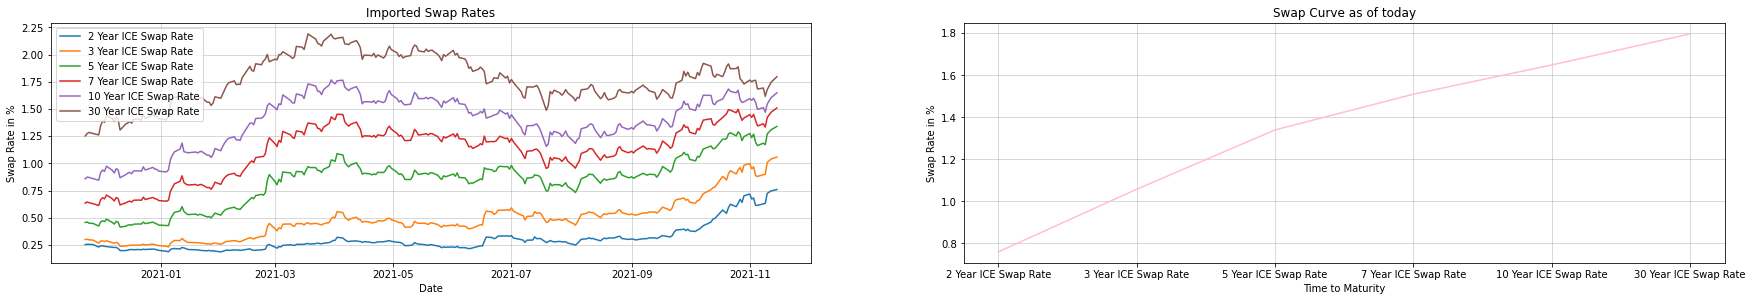

In [430]:
columns = icerates.columns
fig, ax = plt.subplots(figsize=(30,15))
plt.subplot(3,2,1)
for col in columns:
    plt.plot(icerates[col])
    plt.xlabel('Date')
    plt.ylabel('Swap Rate in %')
    plt.title('Imported Swap Rates')
    plt.grid(alpha = 0.6)
    plt.legend(columns)

plt.subplot(3,2,2)
plt.plot(icerates.iloc[-1], color = 'pink')
plt.ylabel('Swap Rate in %')
plt.xlabel('Time to Maturity')
plt.title('Swap Curve as of today')
plt.grid(alpha = 0.6)

NelsonSiegelSvenssonCurve(beta0=13.356626036250573, beta1=-13.639348635615965, beta2=-30.291283664589674, beta3=16.405961619762383, tau1=15.503529684259309, tau2=7.344387552952911)


Text(0.5, 1.0, 'Nielsen - Siegel - Svenson Model Rates from Market Treasury Yields')

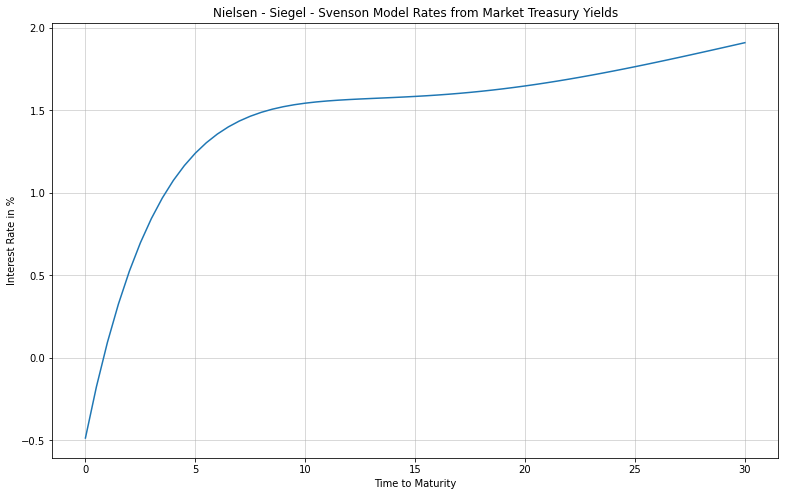

In [431]:
current_market_yields = tyields.iloc[-1].to_numpy()
tenor = np.array([2,3,5,7,10,30])

curve, status = calibrate_nss_ols(tenor, current_market_yields)  
NSS_ZC = NelsonSiegelSvenssonCurve.zero(curve,tenor)
NSS_Fwd = NelsonSiegelSvenssonCurve.forward(curve,tenor)
print(curve)

y = NelsonSiegelSvenssonCurve(3.54800368690387, -4.03306591923748, -53.97020182508623, 53.758205420276745, 6.483657167687587, 5.950831251892924)
t = np.arange(0,30.5,0.5)

extrapolated_rates = pd.DataFrame()
extrapolated_rates['Time to Maturity'] = t
extrapolated_rates['Extrapolated Rates'] = y(t)
extrapolated_rates = extrapolated_rates.set_index("Time to Maturity")

plt.figure(figsize=(13,8))
plt.plot(extrapolated_rates)
plt.grid(alpha = 0.6)
plt.xlabel('Time to Maturity')
plt.ylabel('Interest Rate in %')
plt.title('Nielsen - Siegel - Svenson Model Rates from Market Treasury Yields')


In [432]:
current_market_yields

array([0.63, 0.95, 1.33, 1.55, 1.63, 1.98])

In [433]:
y(t)

array([-0.48506223, -0.17470241,  0.09408133,  0.32621472,  0.52609878,
        0.69766205,  0.84440778,  0.96945666,  1.07558548,  1.16526205,
        1.24067676,  1.30377109,  1.35626333,  1.39967188,  1.43533611,
        1.46443534,  1.48800583,  1.50695612,  1.52208085,  1.53407319,
        1.54353601,  1.5509919 ,  1.55689223,  1.56162522,  1.56552321,
        1.56886913,  1.5719024 ,  1.57482407,  1.5778015 ,  1.58097255,
        1.58444926,  1.58832117,  1.59265827,  1.59751361,  1.60292562,
        1.60892021,  1.61551254,  1.62270866,  1.63050694,  1.63889934,
        1.64787245,  1.65740852,  1.66748628,  1.67808168,  1.68916852,
        1.70071901,  1.71270428,  1.72509473,  1.73786044,  1.75097143,
        1.76439794,  1.77811063,  1.79208074,  1.80628025,  1.820682  ,
        1.83525978,  1.84998836,  1.86484361,  1.87980249,  1.89484307,
        1.90994456])

In [434]:
def swap_to_zero_df(swap_rates):
    """"
    returns the discount factors from the swap rates
    swap_rates should be provided in decimals
    
    """ 
    bootstrapped_dfs = [1 / (1 + swap_rates[0])]
    for i in swap_rates[1:]:
        bootstrapped_dfs.append((1 - i * sum(bootstrapped_dfs)) / (1+i))  
    return bootstrapped_dfs

bootstrapped_dfs = swap_to_zero_df(current_swap_rates/100)

In [435]:
zero_cont_rates = []
for x,y in zip(bootstrapped_dfs, tenor): 
    zero_cont_rates.append(-np.log(x)/y)
